In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_fscore_support

import os

In [2]:
# some funcs
def getFiles(organName, listDir, prefix=None):
    """
    Generate list of files associa-
    ted with each organ of interest
    in the list of files.
    --------------------------
    Input:
        organ_list: list of organs
                    str
        listDir:    list of files  
                    to search
        prefix:     OS path prefix
    Output:
        lists:      list of files 
                    associated with
                    organ
    """
    # get the files from listDir that contain 'organName'
    matching = [file for file in listDir if organName in file]
    
    # append the path prefix so that files are accessible
    if prefix:
        matchingFixed = [prefix + file for file in matching]
        return matchingFixed
    
    else:
        return matching

In [3]:
def cleanDocs(docList):
    '''
    Clean up labels and load as csv's.
    Labels are changed to binary.
    '''
    dfs = []
    binary_Map = {'Present': 1, 'Absent': 0}
    for doc in docList:
        df = pd.read_csv(doc)
        df['label'] = [df['label'][j][2:-2] for j,i in enumerate(df['label'])]
        df['label'] = df['label'].map(binary_Map)
        
        dfs.append(df)

    return dfs

In [4]:
# set a random seed
np.random.seed(500)

In [5]:
# get data
dataPath = '../data_200/recombined/'
# should be the list of all files
dataList = os.listdir(dataPath)
dataList = [dataPath + file for file in dataList]

In [6]:
# all abnormal findings data
abnormalFindings = getFiles('Abnormal Findings', dataList)
abnormalFindings_dfs = cleanDocs(abnormalFindings)
AF_df = pd.concat(abnormalFindings_dfs)

### Data Preprocessing

In [7]:
AF_df.head()

,idx,sentence,label
0,5fddb3bdeaf0903792b63904,Gastrostomy tube in place. No evidence of co...,0
1,6046c8dfc7274cd918d2870b,Extensive multifocal areas of bowel wall thi...,0
2,5e46a9a85808eee774f693f0,Interval placement of duodenal stent in the d...,0
3,5f5b7067d8d9aa5228644e8e,Unremarkable \r\n Vasculature: Portal ve...,0
4,5e4659115808eee77438cd61,Unremarkable Pelvis: Unremarkable \r\n,0


In [8]:
# change all text to lower case
AF_df['sentence'] = [entry.lower() for entry in AF_df['sentence']]

# tokenization: in this each entry in the corpus will be broken into a set of words
#AF_df['sentence'] = [word_tokenize(entry) for entry in AF_df['sentence']]


In [9]:
AF_df['sentence']

0        gastrostomy tube in place. no evidence of co...
1        extensive multifocal areas of bowel wall thi...
2       interval placement of duodenal stent in the d...
3        unremarkable    \r\n vasculature:  portal ve...
4         unremarkable    pelvis:  unremarkable    \r\n 
                             ...                        
195     for chest findings, please see the  separatel...
196      for chest findings, please see the separatel...
197      right upper lobe subpleural noncalcified pul...
198      for chest findings, please see the separatel...
199     for chest findings, please see the  separatel...
Name: sentence, Length: 2200, dtype: object

### Splitting

In [10]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(AF_df['sentence'],
                                                                    AF_df['label'],
                                                                    test_size=0.2)

### Encoding
Label encode the target variable, done to transform categorical data of string type in the dataset into numerical values so that the model can understand.

In [11]:
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)

### Word Vectorization
Turning a collection of text documents into numerical feature vectors. 
Here we use TFIDF: Term Frequency -- Inverse Document
- Term Frequency: This summarizes how often a given word appears within a document
- Inverse Document Frequency: This down scales words that appear a lot across documents.

In [12]:
tfidf_vect = TfidfVectorizer(max_features=5000)
tfidf_vect.fit(AF_df['sentence'])

X_train_tfidf = tfidf_vect.transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)

In [13]:
#print(tfidf_vect.vocabulary_) # are these counts?

datasets ar enow ready to be fed into different classification algorithms

### Naive Bayes

Naive Bayes Accuracy Score ->  85.45454545454545
Naive Bayes Precision Score ->  46.464646464646464
Naive Bayes Recall Score ->  80.7017543859649
Naive Bayes Prec Recall Support Score ->  (0.8545454545454545, 0.8545454545454545, 0.8545454545454545, None)


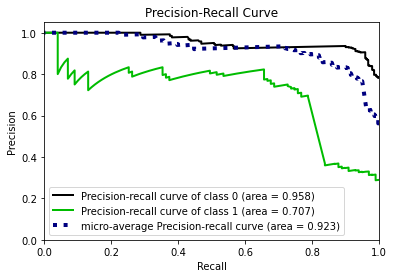

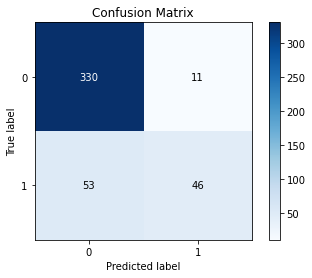

In [29]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(X_train_tfidf, y_train)

# predict the labels on validation dataset
predictions_NB = Naive.predict(X_test_tfidf)
prob_NB = Naive.predict_proba(X_test_tfidf)

# use accuracy score function to ge the accuracy
print("Naive Bayes Accuracy Score -> ", accuracy_score(predictions_NB, y_test)*100)
print("Naive Bayes Precision Score -> ", precision_score(predictions_NB, y_test)*100)
print("Naive Bayes Recall Score -> ", recall_score(predictions_NB, y_test)*100)
print("Naive Bayes Prec Recall Support Score -> ", precision_recall_fscore_support(predictions_NB, y_test,
                                                                                  average='micro', labels=[0, 1]))
skplt.metrics.plot_precision_recall(y_test, prob_NB)
skplt.metrics.plot_confusion_matrix(y_test, predictions_NB)
plt.show()

### SVM

SVM Accuracy Score ->  83.86363636363636
SVM Precision Score ->  72.72727272727273
SVM Recall Score ->  62.06896551724138
SVM Prec Recall Support Score ->  (0.8386363636363636, 0.8386363636363636, 0.8386363636363636, None)


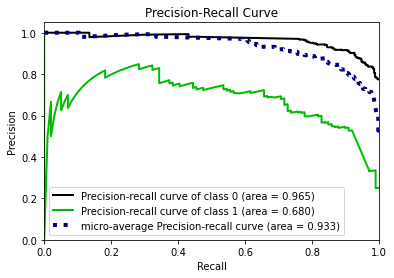

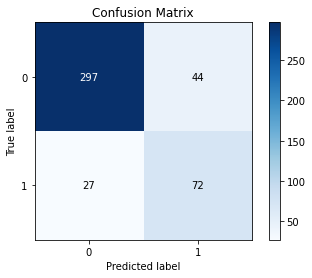

In [26]:
import scikitplot as skplt
import matplotlib.pyplot as plt

# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', probability=True, class_weight='balanced')
SVM.fit(X_train_tfidf, y_train)

# predict the labels on validation dataset
predictions_SVM = SVM.predict(X_test_tfidf)
prob_SVM = SVM.predict_proba(X_test_tfidf)

# get metrics 
print("SVM Accuracy Score -> ", accuracy_score(predictions_SVM, y_test)*100)
print("SVM Precision Score -> ", precision_score(predictions_SVM, y_test)*100)
print("SVM Recall Score -> ", recall_score(predictions_SVM, y_test)*100)
print("SVM Prec Recall Support Score -> ", precision_recall_fscore_support(predictions_SVM, y_test,
                                                                                  average='micro', labels=[0, 1]))

skplt.metrics.plot_precision_recall(y_test, prob_SVM)
skplt.metrics.plot_confusion_matrix(y_test, predictions_SVM)
plt.show()

## Training all classifiers: liver and pancreas
- Liver and Pancreas
- Classifiers:
    - Disease location
    - Abnormal Findings
    - Previous surgeries

### Data 

In [39]:
# disease location: liver and pancreas
diseaseloc = getFiles('disease_location', dataList)
liver = getFiles('Liver', diseaseloc)
pancreas = getFiles('Pancreas', diseaseloc)
dl_files = liver + pancreas
diseaseloc_dfs = cleanDocs(dl_files)
DL_df = pd.concat(diseaseloc_dfs)

# abnormal findings: liver and pancreas
abnormalFinds = getFiles('Abnormal Findings', dataList)
liver_af = getFiles('Liver', abnormalFinds)
pancreas_af = getFiles('Pancreas', abnormalFinds)
af_files = liver_af + pancreas_af
af_dfs = cleanDocs(af_files)
AF_df = pd.concat(af_dfs)

# previous surgeries: liver and pancreas
prevSurgeries = getFiles('Previous Surgeries', dataList)
liver_ps = getFiles('Liver', prevSurgeries)
pancreas_ps = getFiles('Pancreas', prevSurgeries)
ps_files = liver_ps + pancreas_ps
ps_dfs = cleanDocs(ps_files)
PS_df = pd.concat(ps_dfs)

In [46]:
all_ = [DL_df, AF_df, PS_df]
names = ['DISEASE LOCATION', 'ABNORMAL FINDINGS', 'PREVIOUS SURGERIES']

### Preprocess, encode, train, test.

************************************************************
CLASSIFIER:  DISEASE LOCATION
************************************************************
Naive Bayes Accuracy Score ->  82.5
Naive Bayes Precision Score ->  75.60975609756098
Naive Bayes Recall Score ->  88.57142857142857
Naive Bayes Prec Recall Support Score ->  (0.825, 0.825, 0.825, None)


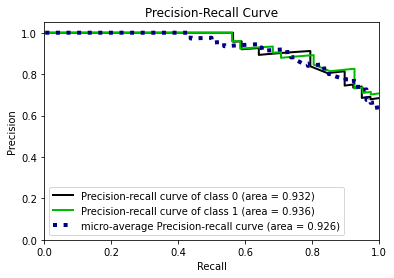

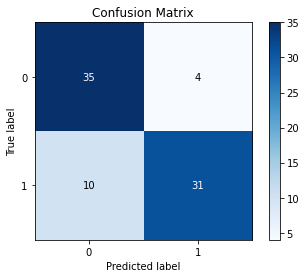

SVM Accuracy Score ->  87.5
SVM Precision Score ->  90.2439024390244
SVM Recall Score ->  86.04651162790698
SVM Prec Recall Support Score ->  (0.875, 0.875, 0.875, None)


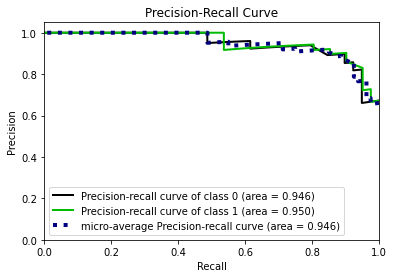

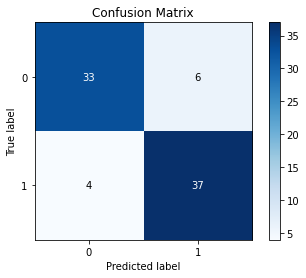

************************************************************
CLASSIFIER:  ABNORMAL FINDINGS
************************************************************
Naive Bayes Accuracy Score ->  85.0
Naive Bayes Precision Score ->  95.45454545454545
Naive Bayes Recall Score ->  80.76923076923077
Naive Bayes Prec Recall Support Score ->  (0.85, 0.85, 0.85, None)


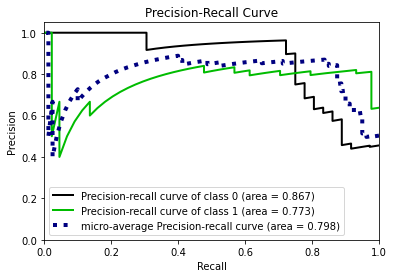

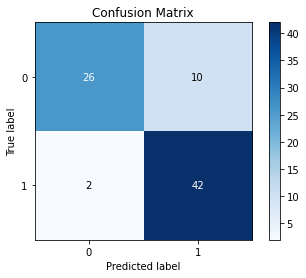

SVM Accuracy Score ->  85.0
SVM Precision Score ->  93.18181818181817
SVM Recall Score ->  82.0
SVM Prec Recall Support Score ->  (0.85, 0.85, 0.85, None)


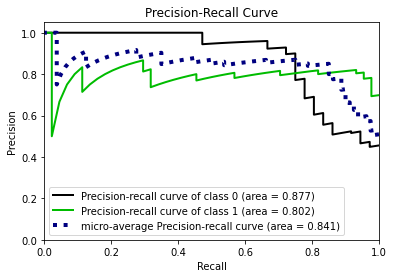

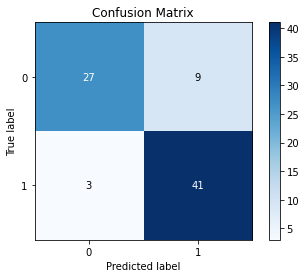

************************************************************
CLASSIFIER:  PREVIOUS SURGERIES
************************************************************
Naive Bayes Accuracy Score ->  85.18518518518519
Naive Bayes Precision Score ->  33.33333333333333
Naive Bayes Recall Score ->  100.0
Naive Bayes Prec Recall Support Score ->  (0.8518518518518519, 0.8518518518518519, 0.8518518518518519, None)


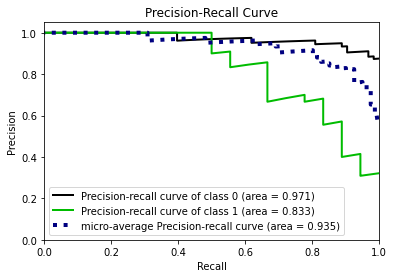

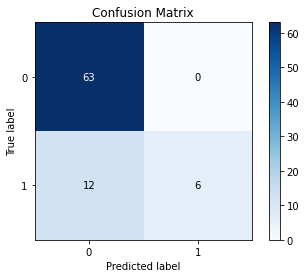

SVM Accuracy Score ->  92.5925925925926
SVM Precision Score ->  66.66666666666666
SVM Recall Score ->  100.0
SVM Prec Recall Support Score ->  (0.9259259259259259, 0.9259259259259259, 0.9259259259259259, None)


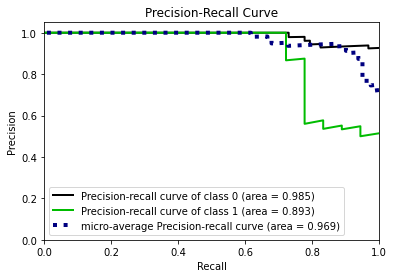

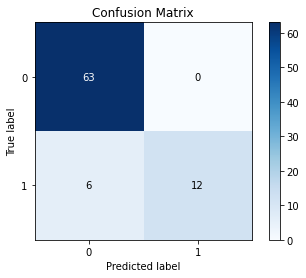

In [47]:
for i,frame in enumerate(all_):
    
    # lower case
    frame['sentence'] = [entry.lower() for entry in frame['sentence']]
    
    # data splitting (80/20)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(frame['sentence'],
                                                                    frame['label'],
                                                                    test_size=0.2)
    # encoding
    Encoder = LabelEncoder()
    y_train = Encoder.fit_transform(y_train)
    y_test = Encoder.fit_transform(y_test)
    
    # word vectorization
    tfidf_vect = TfidfVectorizer(max_features=5000)
    tfidf_vect.fit(frame['sentence'])

    X_train_tfidf = tfidf_vect.transform(X_train)
    X_test_tfidf = tfidf_vect.transform(X_test)
    
    # ---------------TRAIN : Naive Bayes
    Naive = naive_bayes.MultinomialNB()
    Naive.fit(X_train_tfidf, y_train)

    # predict the labels on validation dataset
    predictions_NB = Naive.predict(X_test_tfidf)
    prob_NB = Naive.predict_proba(X_test_tfidf)
    print("***"*20)
    print("CLASSIFIER: ", names[i])
    print("***"*20)
    # use accuracy score function to ge the accuracy
    print("Naive Bayes Accuracy Score -> ", accuracy_score(predictions_NB, y_test)*100)
    print("Naive Bayes Precision Score -> ", precision_score(predictions_NB, y_test)*100)
    print("Naive Bayes Recall Score -> ", recall_score(predictions_NB, y_test)*100)
    print("Naive Bayes Prec Recall Support Score -> ", precision_recall_fscore_support(predictions_NB, y_test,
                                                                                      average='micro', labels=[0, 1]))
    skplt.metrics.plot_precision_recall(y_test, prob_NB)
    skplt.metrics.plot_confusion_matrix(y_test, predictions_NB)
    plt.show()
    
    
    # ---------------TRAIN : SVM
    # fit the training dataset on the classifier
    SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', probability=True, class_weight='balanced')
    SVM.fit(X_train_tfidf, y_train)

    # predict the labels on validation dataset
    predictions_SVM = SVM.predict(X_test_tfidf)
    prob_SVM = SVM.predict_proba(X_test_tfidf)

    # get metrics 
    print("SVM Accuracy Score -> ", accuracy_score(predictions_SVM, y_test)*100)
    print("SVM Precision Score -> ", precision_score(predictions_SVM, y_test)*100)
    print("SVM Recall Score -> ", recall_score(predictions_SVM, y_test)*100)
    print("SVM Prec Recall Support Score -> ", precision_recall_fscore_support(predictions_SVM, y_test,
                                                                                      average='micro', labels=[0, 1]))

    skplt.metrics.plot_precision_recall(y_test, prob_SVM)
    skplt.metrics.plot_confusion_matrix(y_test, predictions_SVM)
    plt.show()

## Training all classifiers: all organs
- Disease location
- Abnormal findings
- Previous surgeries

### Data

In [48]:
# disease location: liver and pancreas
diseaseloc = getFiles('disease_location', dataList)
diseaseloc_dfs = cleanDocs(diseaseloc)
DL_df = pd.concat(diseaseloc_dfs)

# abnormal findings: liver and pancreas
abnormalFinds = getFiles('Abnormal Findings', dataList)
af_dfs = cleanDocs(abnormalFinds)
AF_df = pd.concat(af_dfs)

# previous surgeries: liver and pancreas
prevSurgeries = getFiles('Previous Surgeries', dataList)
ps_dfs = cleanDocs(prevSurgeries)
PS_df = pd.concat(ps_dfs)

### Preprocessing, encoding, training and testing

************************************************************
CLASSIFIER:  DISEASE LOCATION
************************************************************
Naive Bayes Accuracy Score ->  87.5
Naive Bayes Precision Score ->  79.41176470588235
Naive Bayes Recall Score ->  90.0
Naive Bayes Prec Recall Support Score ->  (0.875, 0.875, 0.875, None)


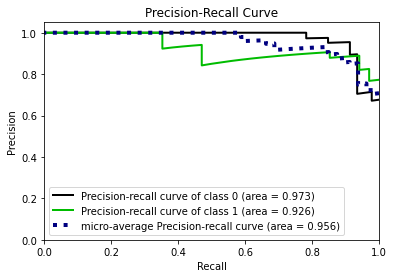

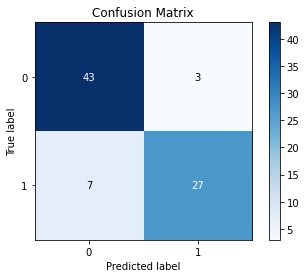

SVM Accuracy Score ->  88.75
SVM Precision Score ->  88.23529411764706
SVM Recall Score ->  85.71428571428571
SVM Prec Recall Support Score ->  (0.8875, 0.8875, 0.8875, None)


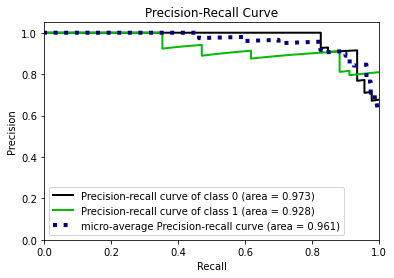

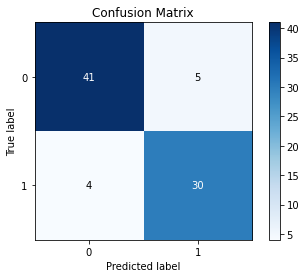

************************************************************
CLASSIFIER:  ABNORMAL FINDINGS
************************************************************
Naive Bayes Accuracy Score ->  85.0
Naive Bayes Precision Score ->  87.75510204081633
Naive Bayes Recall Score ->  87.75510204081633
Naive Bayes Prec Recall Support Score ->  (0.85, 0.85, 0.85, None)


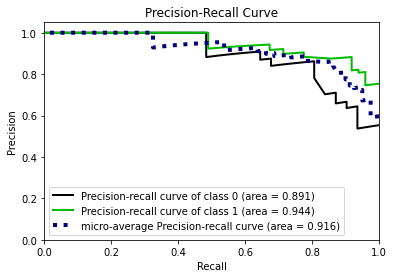

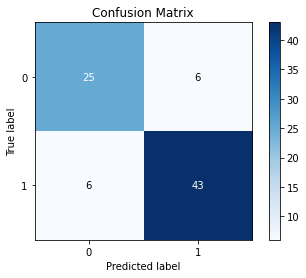

SVM Accuracy Score ->  82.5
SVM Precision Score ->  85.71428571428571
SVM Recall Score ->  85.71428571428571
SVM Prec Recall Support Score ->  (0.825, 0.825, 0.825, None)


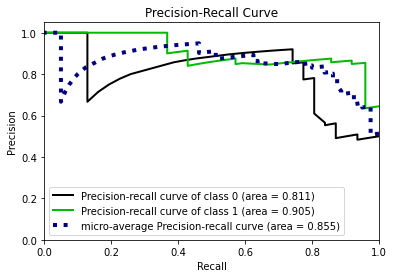

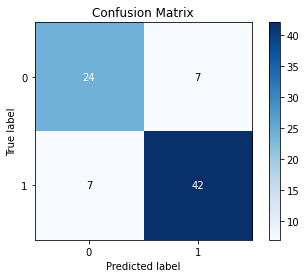

************************************************************
CLASSIFIER:  PREVIOUS SURGERIES
************************************************************
Naive Bayes Accuracy Score ->  83.9506172839506
Naive Bayes Precision Score ->  38.095238095238095
Naive Bayes Recall Score ->  100.0
Naive Bayes Prec Recall Support Score ->  (0.8395061728395061, 0.8395061728395061, 0.8395061728395061, None)


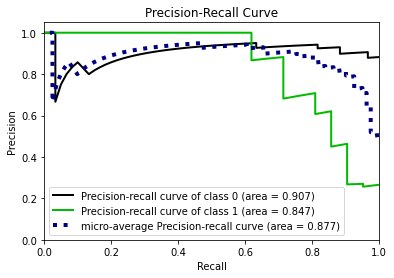

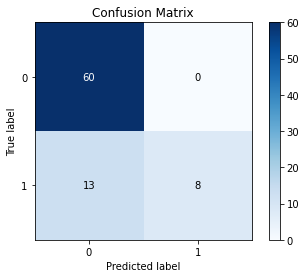

SVM Accuracy Score ->  92.5925925925926
SVM Precision Score ->  80.95238095238095
SVM Recall Score ->  89.47368421052632
SVM Prec Recall Support Score ->  (0.9259259259259259, 0.9259259259259259, 0.9259259259259259, None)


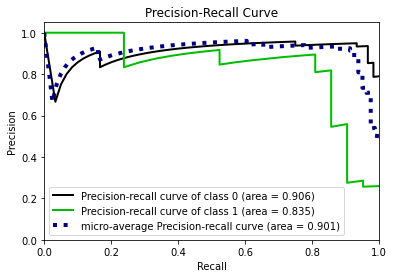

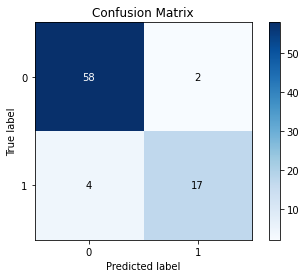

In [57]:
for i,frame in enumerate(all_):
    
    # lower case
    frame['sentence'] = [entry.lower() for entry in frame['sentence']]
    
    # data splitting (80/20)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(frame['sentence'],
                                                                    frame['label'],
                                                                    test_size=0.2)
    # encoding
    Encoder = LabelEncoder()
    y_train = Encoder.fit_transform(y_train)
    y_test = Encoder.fit_transform(y_test)
    
    # word vectorization
    tfidf_vect = TfidfVectorizer(max_features=5000)
    tfidf_vect.fit(frame['sentence'])

    X_train_tfidf = tfidf_vect.transform(X_train)
    X_test_tfidf = tfidf_vect.transform(X_test)
    
    # ---------------TRAIN : Naive Bayes
    Naive = naive_bayes.MultinomialNB()
    Naive.fit(X_train_tfidf, y_train)

    # predict the labels on validation dataset
    predictions_NB = Naive.predict(X_test_tfidf)
    prob_NB = Naive.predict_proba(X_test_tfidf)
    print("***"*20)
    print("CLASSIFIER: ", names[i])
    print("***"*20)
    # use accuracy score function to ge the accuracy
    print("Naive Bayes Accuracy Score -> ", accuracy_score(predictions_NB, y_test)*100)
    print("Naive Bayes Precision Score -> ", precision_score(predictions_NB, y_test)*100)
    print("Naive Bayes Recall Score -> ", recall_score(predictions_NB, y_test)*100)
    print("Naive Bayes Prec Recall Support Score -> ", precision_recall_fscore_support(predictions_NB, y_test,
                                                                                      average='micro', labels=[0, 1]))
    skplt.metrics.plot_precision_recall(y_test, prob_NB)
    skplt.metrics.plot_confusion_matrix(y_test, predictions_NB)
    plt.show()
    
    
    # ---------------TRAIN : SVM
    # fit the training dataset on the classifier
    SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', probability=True, class_weight='balanced')
    SVM.fit(X_train_tfidf, y_train)

    # predict the labels on validation dataset
    predictions_SVM = SVM.predict(X_test_tfidf)
    prob_SVM = SVM.predict_proba(X_test_tfidf)

    # get metrics 
    print("SVM Accuracy Score -> ", accuracy_score(predictions_SVM, y_test)*100)
    print("SVM Precision Score -> ", precision_score(predictions_SVM, y_test)*100)
    print("SVM Recall Score -> ", recall_score(predictions_SVM, y_test)*100)
    print("SVM Prec Recall Support Score -> ", precision_recall_fscore_support(predictions_SVM, y_test,
                                                                                      average='micro', labels=[0, 1]))

    skplt.metrics.plot_precision_recall(y_test, prob_SVM)
    skplt.metrics.plot_confusion_matrix(y_test, predictions_SVM)
    plt.show()